In [1]:
from scipy.io import loadmat, savemat
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss
from dstft import DSTFT, FDSTFT
from dstft import frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802)

In [2]:
mat = loadmat('../data/x_vitesse2.mat')['xt']
x = torch.from_numpy(mat).float().to(device)[:, 38_000:60_000]
vitesse = {}

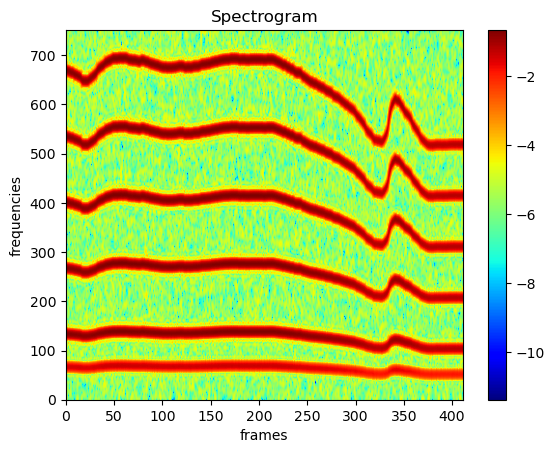

In [3]:
dstft = FDSTFT(x, win_length=200, support=1_500, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
vitesse['100'] = spec.cpu() #.numpy()

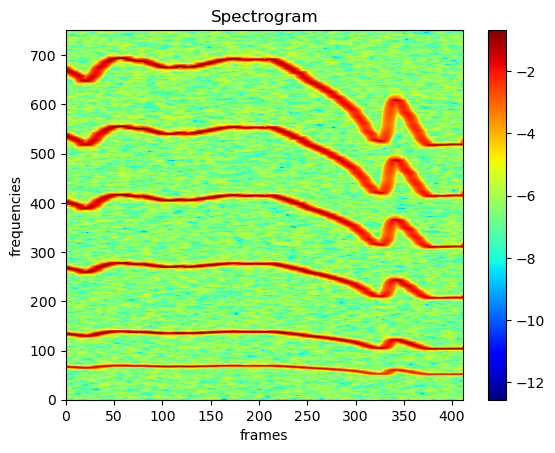

In [4]:
dstft = FDSTFT(x, win_length=1000, support=1_500, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
vitesse['1500'] = spec.cpu() #.numpy()

Single window length

792 tensor(10.7024, device='cuda:0')


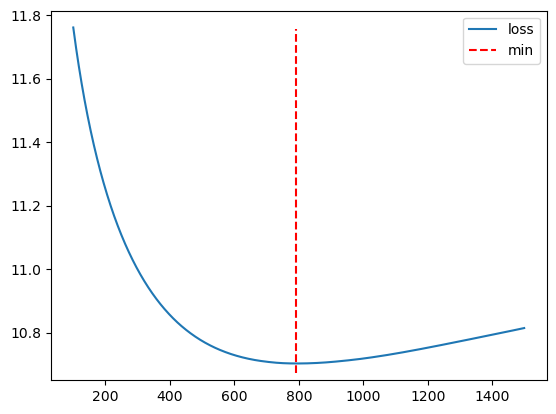

In [6]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 1500, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1_500, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
plt.plot(range(100, 1500, 1), losses, label='loss')
plt.axvline(x=min_win, ymin=0.02, ymax=0.95,  color='red', linestyle ='--', label='min')
#plt.axvline(x=100, ymin=0.02, ymax=0.95,  color='green', linestyle ='--', label='100')
#plt.axvline(x=1000, ymin=0.02, ymax=0.95,  color='orange', linestyle ='--', label='1000')
plt.legend()
plt.show()

Epoch 00102: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00202: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00302: reducing learning rate of group 0 to 1.0000e-01.
301
794.3064575195312 tensor(10.7024, device='cuda:0', grad_fn=<MeanBackward0>)


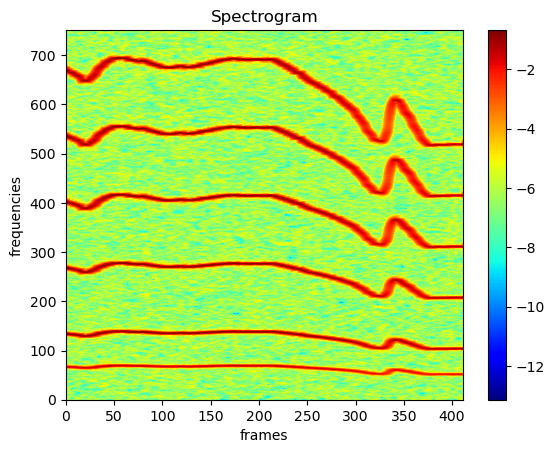

792.9


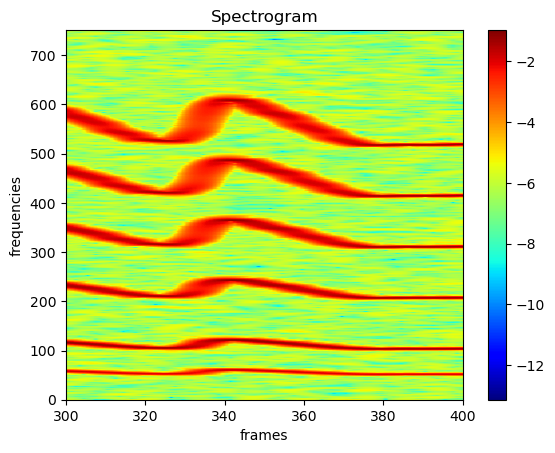

In [12]:
dstft = FDSTFT(x, win_length=877, support=1_500, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')
vitesse['single'] = spec.detach().cpu() #.numpy()

plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(spec[0, ..., 300:400].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[300, 400, 0, spec.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()


Time-varying window length

Epoch 00134: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00234: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00334: reducing learning rate of group 0 to 1.0000e-01.
333


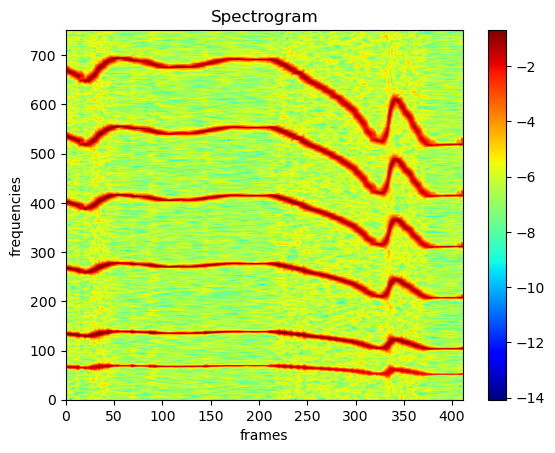

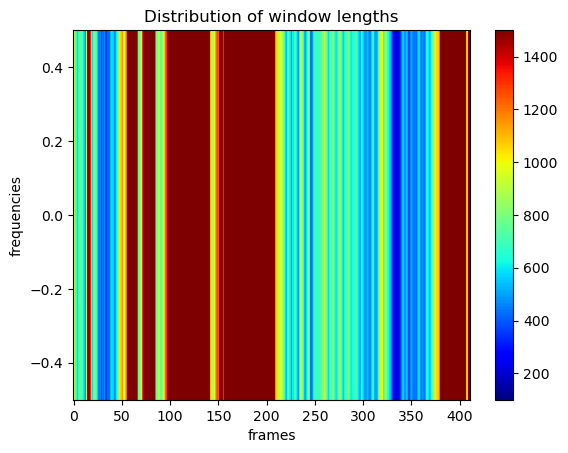

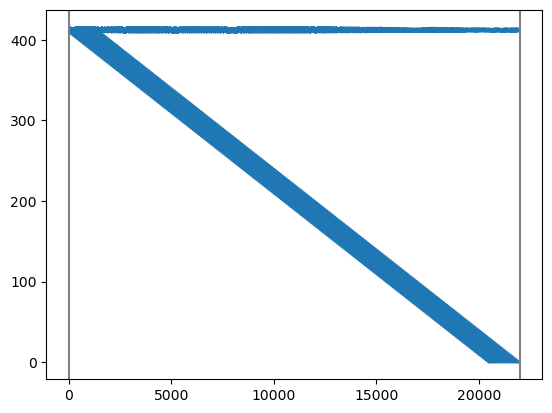

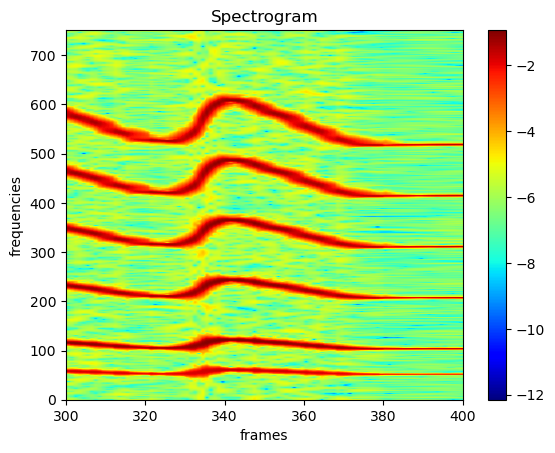

In [13]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(spec[0, ..., 300:400].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[300, 400, 0, spec.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()


Epoch 00341: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00470: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00574: reducing learning rate of group 0 to 1.0000e-01.
573


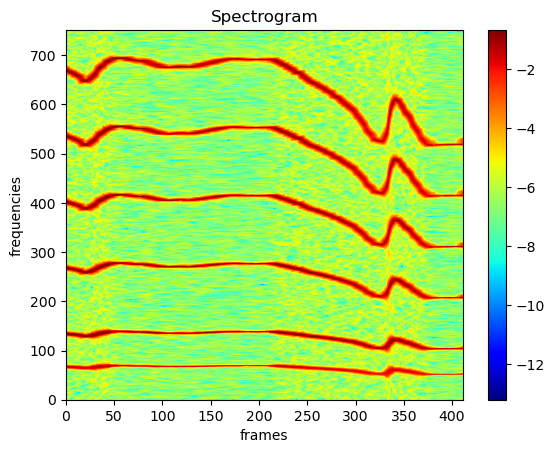

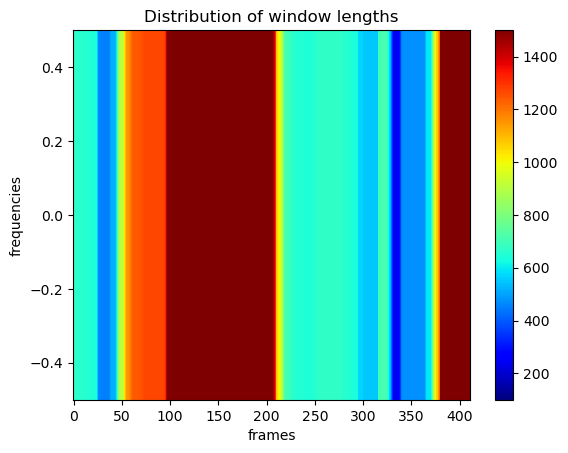

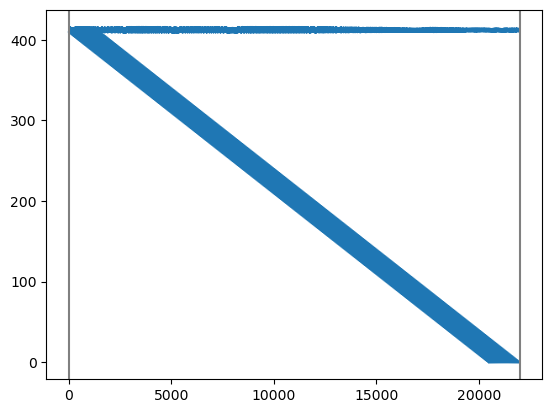

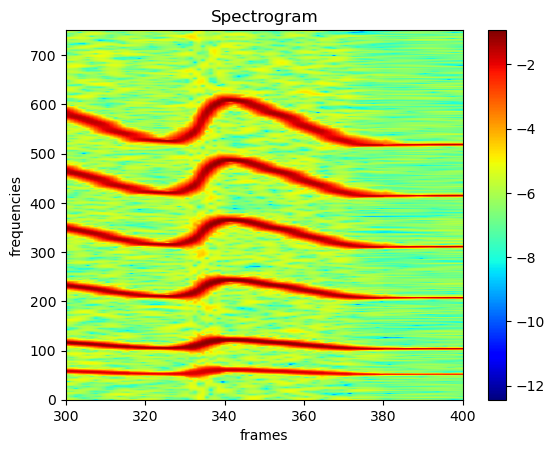

In [14]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True)
vitesse['time_varying'] = spec.detach().cpu() #.numpy()

plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(spec[0, ..., 300:400].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[300, 400, 0, spec.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

In [7]:
dstft = DSTFT(x, win_length=800, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.57 GiB (GPU 0; 15.74 GiB total capacity; 13.70 GiB already allocated; 30.62 MiB free; 15.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
savemat('../data/vitesse.mat', vitesse)

In [16]:
print(vitesse.keys(), vitesse['time_varying'].shape, x.shape)
spec = vitesse['time_varying'][0]

dict_keys(['100', '1500', 'single', 'time_varying']) torch.Size([1, 751, 411]) torch.Size([1, 22000])


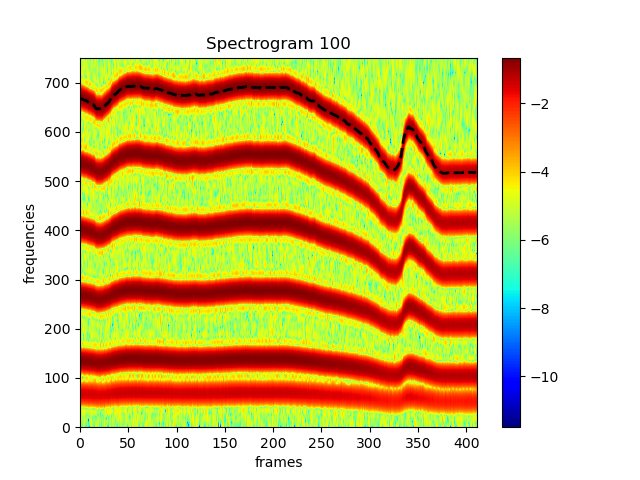

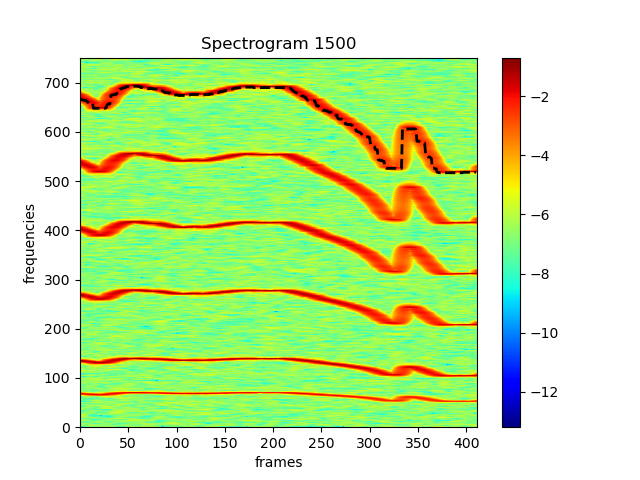

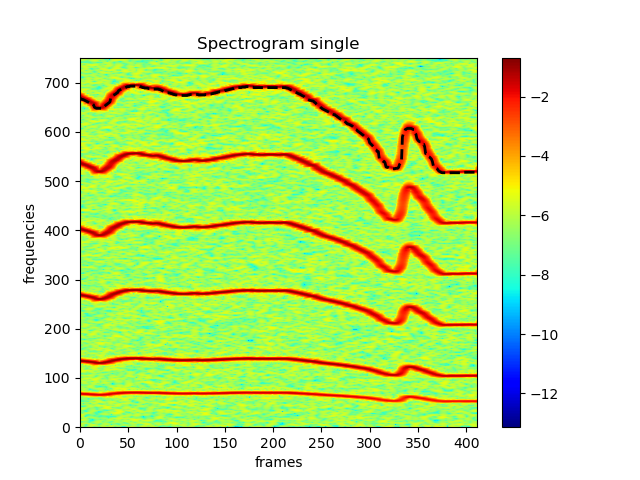

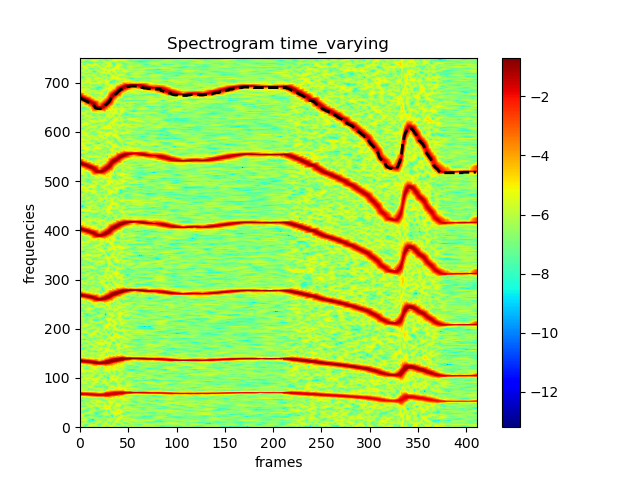

In [17]:
%matplotlib ipympl

freq = {}
outs = {}
for key, spec in vitesse.items():
    spec = spec[0]
    f_hat, out = frequency_tracking(y=x, fs=1, spec=spec, fmin=0, fmax=.5, alpha=100, orders=[.1, .2, .4, .6, .8, ])
    freq[key] = f_hat
    outs[key] = out
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(spec.detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out, '--k', linewidth=2)
    plt.show()

torch.Size([22000])
torch.Size([411])


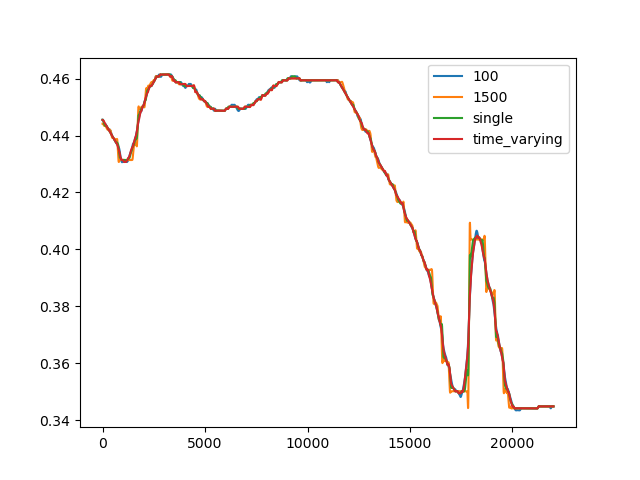

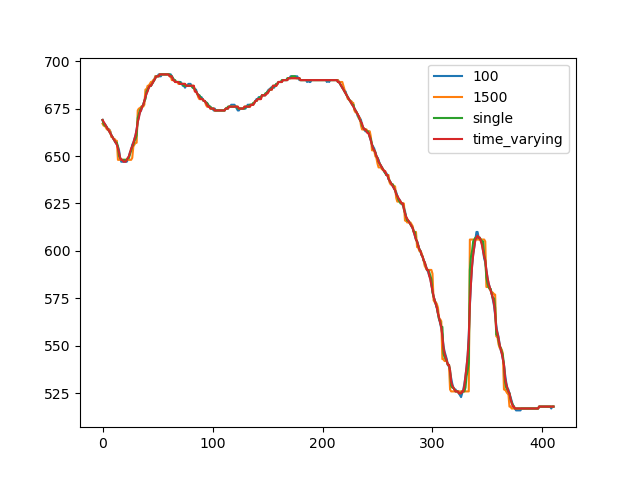

In [18]:
plt.figure()
for key, f in freq.items():
    plt.plot(f, label=key)
plt.legend()

print(f.shape)

plt.figure()
for key, out in outs.items():
    plt.plot(out, label=key)
plt.legend()

print(out.shape)